In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

import pickle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <h1>RNN</h1>

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Faks/diplomski/emotions.csv')

In [4]:
data.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


Odsječak vremenskih podataka iz dataseta

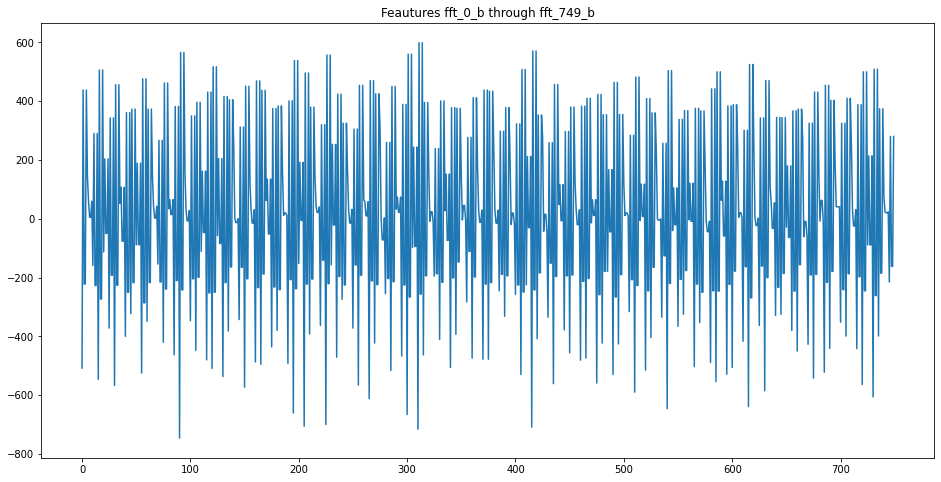

In [5]:
sample = data.loc[0, 'fft_0_b':'fft_749_b']
plt.figure(figsize=(16, 8))
plt.plot(range(len(sample)), sample)
plt.title('Feautures fft_0_b through fft_749_b')
plt.show()

In [6]:
data['label'].value_counts()

NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: label, dtype: int64

In [3]:
label_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}

In [4]:
df = data.copy()
    
df['label'] = df['label'].replace(label_mapping)
    
y = df['label'].copy()
x = df.drop('label', axis=1).copy()
    
RNN_x_train, RNN_x_test, RNN_y_train, RNN_y_test = train_test_split(x, y, train_size=0.7, random_state=123)

Korišteni model za RNN arhitekturu

In [9]:
inputs = tf.keras.Input(shape=(RNN_x_train.shape[1],))

expand_dims = tf.expand_dims(inputs, axis=2)
gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)
flatten = tf.keras.layers.Flatten()(gru)
outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)

RNN_model = tf.keras.Model(inputs=inputs, outputs=outputs)

RNN_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
RNN_model.fit(RNN_x_train, RNN_y_train, validation_split=0.2, batch_size=32, epochs=5)

Epoch 1/5
38/38 [==============================] - 223s 6s/step - loss: 1.6705 - accuracy: 0.9656 - val_loss: 5.3378 - val_accuracy: 0.9498
Epoch 2/5
38/38 [==============================] - 223s 6s/step - loss: 0.3683 - accuracy: 0.9883 - val_loss: 11.6037 - val_accuracy: 0.8963
Epoch 3/5
38/38 [==============================] - 220s 6s/step - loss: 0.6036 - accuracy: 0.9883 - val_loss: 3.6824 - val_accuracy: 0.9532
Epoch 4/5
38/38 [==============================] - 226s 6s/step - loss: 0.6625 - accuracy: 0.9891 - val_loss: 3.6045 - val_accuracy: 0.9599
Epoch 5/5
38/38 [==============================] - 232s 6s/step - loss: 0.2063 - accuracy: 0.9950 - val_loss: 1.5176 - val_accuracy: 0.9666


In [32]:
RNN_model = pickle.load(open("/content/drive/MyDrive/Faks/diplomski/NN modeli/RNN_model.pkl", "rb")) #import RNN model

In [33]:
model_acc = RNN_model.evaluate(RNN_x_test, RNN_y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 97.031%


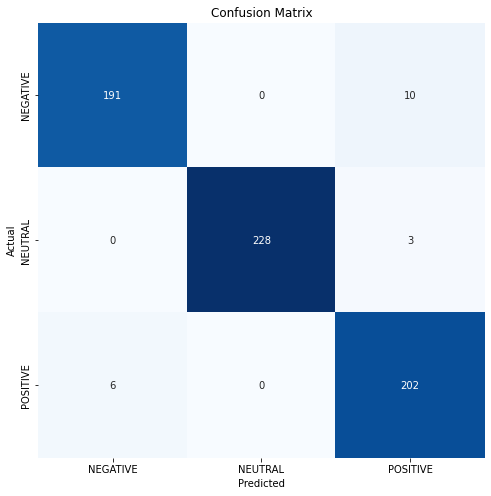

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.97      0.95      0.96       201
     NEUTRAL       1.00      0.99      0.99       231
    POSITIVE       0.94      0.97      0.96       208

    accuracy                           0.97       640
   macro avg       0.97      0.97      0.97       640
weighted avg       0.97      0.97      0.97       640



In [34]:
y_pred = np.array(list(map(lambda x: np.argmax(x), RNN_model.predict(RNN_x_test))))

cm = confusion_matrix(RNN_y_test, y_pred)
clr = classification_report(RNN_y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

# <h1>CNN</h1>

Korišteni model za CNN arhitekturu

In [20]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(219, 217, 4), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
#positive = 0; negative = 1; neutral = 2
def LabelNumerical(labels):
  labels_n = []
  for el in labels:
    if el == 'positive': labels_n.append(0)
    elif el == 'negative': labels_n.append(1)
    elif el == 'neutral': labels_n.append(2)
  return np.array(labels_n)

Zbog velike količine podataka/generiranih slika (preko 7500 slika) nije bilo lako izvesti da se sve iskoriste, ograničenja računala i google colab-a, pa sam uzeo od svake emocionalne reakcije po 1000 slika (sve ukupno 3000 slika).

## <h3>GASF<h3>

In [36]:
gasf_x_train = np.load('/content/drive/MyDrive/Faks/diplomski/GASF/train_test1000/x_train.npy')
gasf_y_train = np.load('/content/drive/MyDrive/Faks/diplomski/GASF/train_test1000/y_train.npy')
gasf_x_test = np.load('/content/drive/MyDrive/Faks/diplomski/GASF/train_test1000/x_test.npy')
gasf_y_test = np.load('/content/drive/MyDrive/Faks/diplomski/GASF/train_test1000/y_test.npy')

In [37]:
gasf_y_train_n = LabelNumerical(gasf_y_train)
gasf_y_test_n = LabelNumerical(gasf_y_test)

In [30]:
model.fit(gasf_x_train, gasf_y_train_n, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
53/53 [==============================] - 79s 1s/step - loss: 0.7180 - accuracy: 0.7440 - val_loss: 0.4129 - val_accuracy: 0.8595
Epoch 2/5
53/53 [==============================] - 75s 1s/step - loss: 0.2791 - accuracy: 0.9036 - val_loss: 0.4903 - val_accuracy: 0.8214
Epoch 3/5
53/53 [==============================] - 75s 1s/step - loss: 0.2041 - accuracy: 0.9310 - val_loss: 0.2643 - val_accuracy: 0.9095
Epoch 4/5
53/53 [==============================] - 76s 1s/step - loss: 0.1317 - accuracy: 0.9565 - val_loss: 0.2997 - val_accuracy: 0.9000
Epoch 5/5
53/53 [==============================] - 75s 1s/step - loss: 0.1058 - accuracy: 0.9661 - val_loss: 0.2574 - val_accuracy: 0.9095


In [38]:
GASF_model = pickle.load(open("/content/drive/MyDrive/Faks/diplomski/NN modeli/GASF_model.pkl", "rb")) #import GASF model

In [48]:
_, acc_gasf = GASF_model.evaluate(gasf_x_test, gasf_y_test_n)
print("Test Accuracy [GASF]: {:.3f}%".format(acc_gasf * 100))

29/29 [==============================] - 11s 374ms/step - loss: 0.2270 - accuracy: 0.9333
Test Accuracy [GASF]: 93.333%


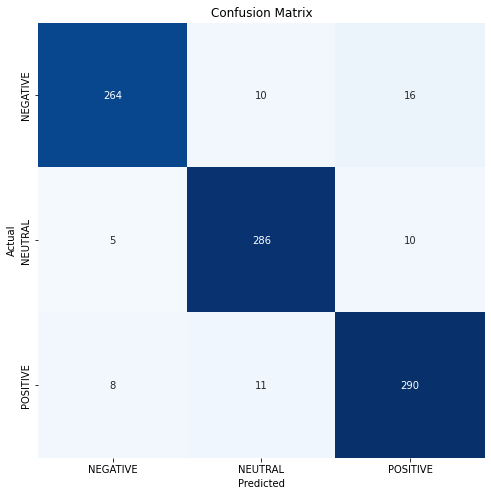

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.95      0.91      0.93       290
     NEUTRAL       0.93      0.95      0.94       301
    POSITIVE       0.92      0.94      0.93       309

    accuracy                           0.93       900
   macro avg       0.93      0.93      0.93       900
weighted avg       0.93      0.93      0.93       900



In [43]:
y_pred = np.array(list(map(lambda x: np.argmax(x), GASF_model.predict(gasf_x_test))))

cm = confusion_matrix(gasf_y_test_n, y_pred)
clr = classification_report(gasf_y_test_n, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

## <h3>GADF<h3>

In [27]:
gadf_x_train = np.load('/content/drive/MyDrive/Faks/diplomski/GADF/train_test1000/x_train.npy')
gadf_y_train = np.load('/content/drive/MyDrive/Faks/diplomski/GADF/train_test1000/y_train.npy')
gadf_x_test = np.load('/content/drive/MyDrive/Faks/diplomski/GADF/train_test1000/x_test.npy')
gadf_y_test = np.load('/content/drive/MyDrive/Faks/diplomski/GADF/train_test1000/y_test.npy')

In [30]:
gadf_y_train_n = LabelNumerical(gadf_y_train)
gadf_y_test_n = LabelNumerical(gadf_y_test)

In [24]:
model.fit(gadf_x_train, gadf_y_train_n, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
53/53 [==============================] - 81s 1s/step - loss: 1.0628 - accuracy: 0.7464 - val_loss: 0.2216 - val_accuracy: 0.9357
Epoch 2/5
53/53 [==============================] - 78s 1s/step - loss: 0.1930 - accuracy: 0.9423 - val_loss: 0.1930 - val_accuracy: 0.9405
Epoch 3/5
53/53 [==============================] - 78s 1s/step - loss: 0.1209 - accuracy: 0.9685 - val_loss: 0.1999 - val_accuracy: 0.9405
Epoch 4/5
53/53 [==============================] - 76s 1s/step - loss: 0.0670 - accuracy: 0.9821 - val_loss: 0.2017 - val_accuracy: 0.9405
Epoch 5/5
53/53 [==============================] - 77s 1s/step - loss: 0.0256 - accuracy: 0.9935 - val_loss: 0.2340 - val_accuracy: 0.9381


In [25]:
GADF_model = pickle.load(open("/content/drive/MyDrive/Faks/diplomski/NN modeli/GADF_model.pkl", "rb")) #import GADF model

In [31]:
_, acc_gadf = GADF_model.evaluate(gadf_x_test, gadf_y_test_n)
print("Test Accuracy [GADF]: {:.3f}%".format(acc_gadf * 100))

29/29 [==============================] - 10s 319ms/step - loss: 0.1728 - accuracy: 0.9522
Test Accuracy [GADF]: 95.222%


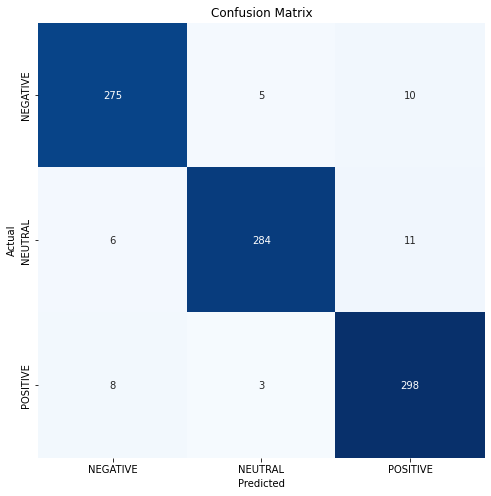

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.95      0.95      0.95       290
     NEUTRAL       0.97      0.94      0.96       301
    POSITIVE       0.93      0.96      0.95       309

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900



In [44]:
y_pred = np.array(list(map(lambda x: np.argmax(x), GADF_model.predict(gadf_x_test))))

cm = confusion_matrix(gadf_y_test_n, y_pred)
clr = classification_report(gadf_y_test_n, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

## <h3>MTF<h3>

In [45]:
mtf_x_train = np.load('/content/drive/MyDrive/Faks/diplomski/MTF/train_test1000/x_train.npy')
mtf_y_train = np.load('/content/drive/MyDrive/Faks/diplomski/MTF/train_test1000/y_train.npy')
mtf_x_test = np.load('/content/drive/MyDrive/Faks/diplomski/MTF/train_test1000/x_test.npy')
mtf_y_test = np.load('/content/drive/MyDrive/Faks/diplomski/MTF/train_test1000/y_test.npy')

In [46]:
mtf_y_train_n = LabelNumerical(mtf_y_train)
mtf_y_test_n = LabelNumerical(mtf_y_test)

In [42]:
model.fit(mtf_x_train, mtf_y_train_n, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
53/53 [==============================] - 79s 1s/step - loss: 0.0057 - accuracy: 0.9988 - val_loss: 1.4559 - val_accuracy: 0.6905
Epoch 2/5
53/53 [==============================] - 77s 1s/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 1.5009 - val_accuracy: 0.7143
Epoch 3/5
53/53 [==============================] - 79s 1s/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 1.5881 - val_accuracy: 0.6952
Epoch 4/5
53/53 [==============================] - 77s 1s/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 1.5906 - val_accuracy: 0.7000
Epoch 5/5
53/53 [==============================] - 79s 1s/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 1.6362 - val_accuracy: 0.7000


In [47]:
MTF_model = pickle.load(open("/content/drive/MyDrive/Faks/diplomski/NN modeli/MTF_model.pkl", "rb")) #import MTF model

In [46]:
_, acc_mtf = MTF_model.evaluate(mtf_x_test, mtf_y_test_n)
print("Test Accuracy [MTF]: {:.3f}%".format(acc_mtf * 100))

29/29 [==============================] - 10s 335ms/step - loss: 1.3733 - accuracy: 0.6844
Test Accuracy [MTF]: 68.444%


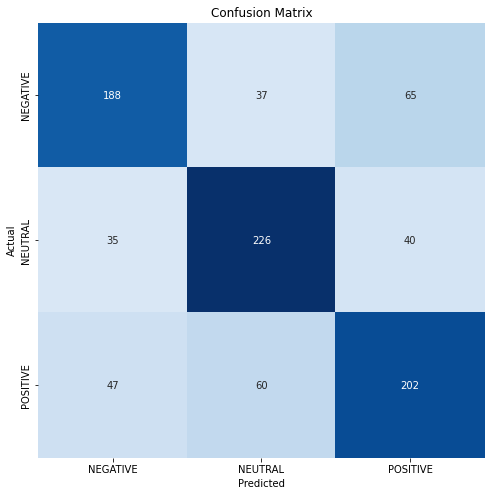

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.70      0.65      0.67       290
     NEUTRAL       0.70      0.75      0.72       301
    POSITIVE       0.66      0.65      0.66       309

    accuracy                           0.68       900
   macro avg       0.68      0.68      0.68       900
weighted avg       0.68      0.68      0.68       900



In [48]:
y_pred = np.array(list(map(lambda x: np.argmax(x), MTF_model.predict(mtf_x_test))))

cm = confusion_matrix(mtf_y_test_n, y_pred)
clr = classification_report(mtf_y_test_n, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

# Algoritmi pretvorbe

Algoritam korišten za procesiranje i prilagodbu podataka, pretvaranje iz vremenskih podataka u slike.

In [5]:
!pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Veličine korištenih slika od korištenih algoritama su image_size=100

## <h2>GAF<h2>

In [7]:
from pyts.image import GramianAngularField as GAF

### <h3>GASF<h3>

(570, 570)


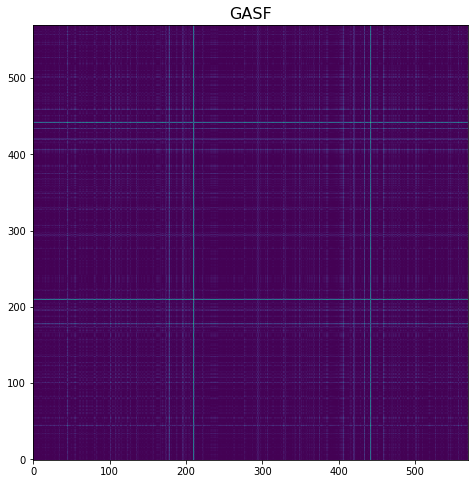

In [8]:
image_size = 570
gasf = GAF(image_size, method='summation')
X_gasf = gasf.fit_transform(df.T)

print(X_gasf[10].shape)
plt.figure(figsize=(8, 8))
plt.imshow(X_gasf[10], cmap='viridis', origin='lower')
plt.title('GASF', fontsize=16)
plt.show()

(100, 100)


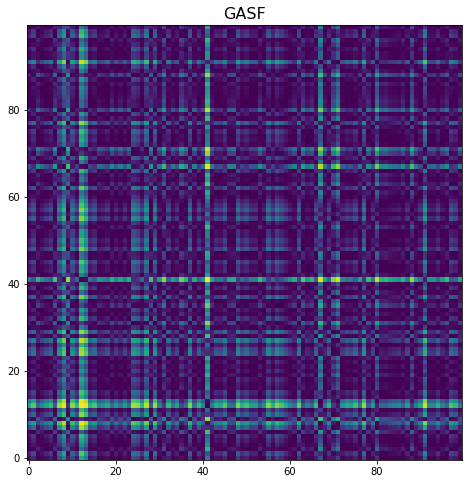

In [9]:
image_size = 100
gasf = GAF(image_size, method='summation')
X_gasf = gasf.fit_transform(df.T)

print(X_gasf[10].shape)
plt.figure(figsize=(8, 8))
plt.imshow(X_gasf[10], cmap='viridis', origin='lower')
plt.title('GASF', fontsize=16)
plt.show()

### <h3>GADF<h3>

(570, 570)


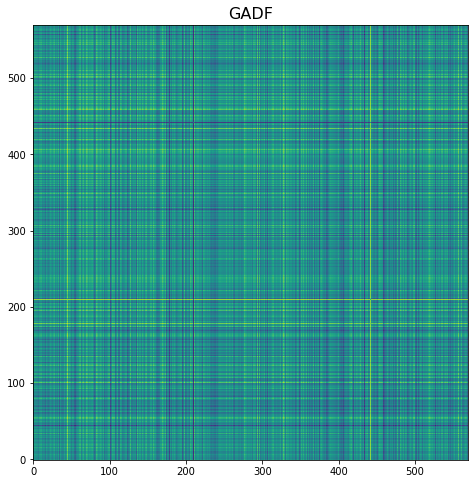

In [10]:
image_size = 570
gadf = GAF(image_size, method='difference')
X_gadf = gadf.fit_transform(df.T)

print(X_gadf[10].shape)
plt.figure(figsize=(8, 8))
plt.imshow(X_gadf[10], cmap='viridis', origin='lower')
plt.title('GADF', fontsize=16)
plt.show()

(100, 100)


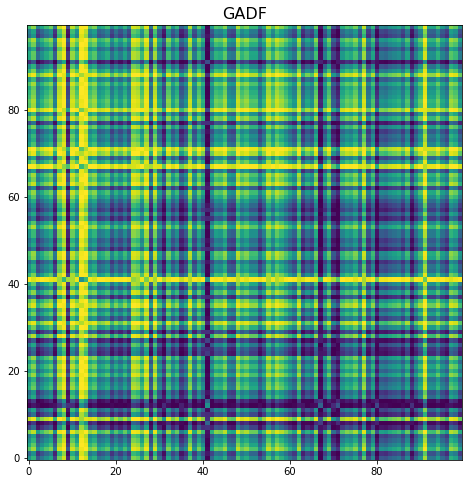

In [11]:
image_size = 100
gadf = GAF(image_size, method='difference')
X_gadf = gadf.fit_transform(df.T)

print(X_gadf[10].shape)
plt.figure(figsize=(8, 8))
plt.imshow(X_gadf[10], cmap='viridis', origin='lower')
plt.title('GADF', fontsize=16)
plt.show()

## <h2>MTF<h2>

In [5]:
from pyts.image import MarkovTransitionField as MTF

In [18]:
short = df.T
df_short = short.head(50)

(570, 570)


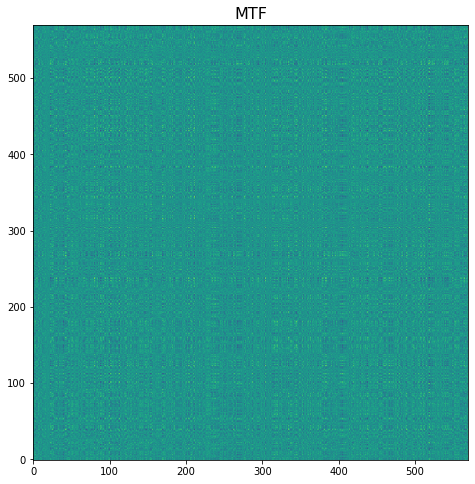

In [23]:
image_size = 570
mtf = MTF(image_size)
X_mtf = mtf.fit_transform(df_short)

print(X_mtf[10].shape)
plt.figure(figsize=(8, 8))
plt.imshow(X_mtf[10], cmap='viridis', origin='lower')
plt.title('MTF', fontsize=16)
plt.show()

(100, 100)


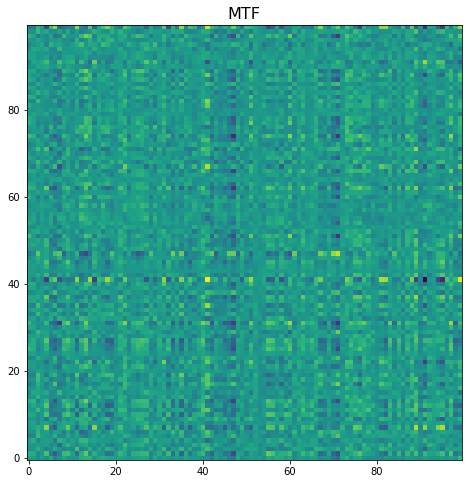

In [24]:
image_size = 100
mtf = MTF(image_size)
X_mtf = mtf.fit_transform(df_short)

print(X_mtf[10].shape)
plt.figure(figsize=(8, 8))
plt.imshow(X_mtf[10], cmap='viridis', origin='lower')
plt.title('MTF', fontsize=16)
plt.show()

# Točnost pri posljednjem treniranju modela:
> RNN arhitektura: 97.031% <br>
> CNN arhitektura<br>
> > GASF: 93.333% <br>
> > GADF: 95.222%<br>
> > MTF: 68.444%